## **Master in Applied Artificial Intelligence**
### **Course: Artificial Intelligence and Automatic Learning**
### Prof. Iván Olmos
#### Tecnológico de Monterrey

### **Result Quality Metrics**
##### **Name and student ID:**
* Mario Guillen de la Torre - A01796701


---


#### **Database Description:**

This notebook processes the dataset of taxi trips in the city of Chicago, applying partitioning rules based on the payment type and pickup zone. Subsequently, representative subsamples are extracted to be used for analyzing tipping behavior.



---

### **Marco Teórico**

#### **I. Data Selection**
As mentioned in previous notebooks, partitioning rules were established based on three characterization variables, selected for their relevance in identifying behavioral patterns:

- Payment_Group: Groups payment methods into Credit Card, Cash, Mobile, and Other. _This variable is fundamental, as there is empirical evidence that passengers who pay with a card tend to leave tips more frequently than those who pay with cash._

- Pickup_zone_group: Corresponds to the starting area of the trip. The most representative community areas were grouped as: 76, 8, 32, 28, and Other (any other area). _This variable is used as a proxy for urban and socioeconomic context, since different areas can reflect different passenger profiles._

- Duration_group: Built from the duration_minutes variable by applying percentile-based binning with the following ranges: Flash Riders ≤10 min, Urban Cruisers between 10 and 23.2 min, and Long-Haul Nomads >23.2 min. _This grouping reflects different types of trips, from short rides typical of urban centers to long journeys, each with different expectations and behaviors associated with the service._

These three variables define the partitioning space, generating combinations that capture different passenger profiles. In total, the result is:

- 4 (payment_group) × 5 (pickup_zone_group) × 3 (duration_group) = **60 partition combinations**

All these combinations describe a wide range of travelers, which inevitably leads to combinations that occur only rarely. To reduce the complexity of our problem, partitions that occur less than 2% of the time within our dataset are merged, reducing the number of combinations to 21 (including the newly merged group).

Each of these partitions represents a distinct travel profile (for example, long trips paid with a card and starting in tourist areas). It is important to emphasize that not all profiles have the same proportion of data, which could introduce bias if the sampling technique is not properly defined. For this reason, stratified sampling was chosen, as it allows extracting a balanced proportion of records across all groups, preventing the model from learning patterns solely from the most frequent profiles.

#### **References**
City of Chicago. (2024). Taxi Trips (2024-) [Data Set].  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://data.cityofchicago.org/Transportation/Taxi-Trips-2024-/ajtu-isnz/about_data

Ahmed, S. K. (2024). Research methodology simplified: how to choose the right sampling technique and determine the appropriate sample size for research.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Oral Oncology Reports, 12, 100662. https://doi.org/10.1016/j.oor.2024.100662

Polak, A. (2023). Scaling Machine Learning with Spark: Distributed ML with MLlib, TensorFlow, and Pytorch. O’Reilly Media.

---

### **Implementation**

#### **Initial Setup**

##### **Importing Libraries**

As a first step, we import the libraries required for the execution of our code.

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Imputer,StringIndexer,OneHotEncoder,StandardScaler,VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, isnan, when, count, percentile_approx, min, max, mean, stddev, approx_count_distinct, expr,  concat_ws, lit
from pyspark.sql.functions import hour, dayofweek, unix_timestamp, when, month,to_timestamp,  dayofweek
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer


from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.clustering import KMeans

import scipy.stats as stats
import pandas as pd
import os
from IPython.display import display, HTML

##### **Creating the Spark Session**

Next, we create our Spark session and define a function that will allow us to display Spark DataFrames in a more user-friendly format. To achieve this, the DataFrame is converted to a pandas DataFrame and rendered using HTML.

In [2]:
spark = SparkSession.builder \
    .appName("ChicagoTaxyTripsAnalysis") \
     .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.python.worker.timeout", "600") \
    .config("spark.python.worker.retries", "3") \
    .getOrCreate()

In [3]:
def pretty_display(df, limit=100):
    pdf = df.limit(limit).toPandas()
    display(HTML(pdf.to_html(notebook=True)))

##### **Loading the Dataset**

We then load our dataset and check the number of rows and columns, giving us an idea of the dataset’s size and dimensions.

In [4]:
filename = "Taxi_Trips__2024-__20250426.csv"
local_path = f"{filename}"
dftaxytrips = spark.read.csv(local_path, header=True, inferSchema=True)

In [5]:
print("Number of records:", dftaxytrips.count())
print("Number of columns:", len(dftaxytrips.columns))

Number of records: 7917844
Number of columns: 23


##### **Data Exploration**

Next, we examine the schema of our dataset, taking note of the columns that are of textual type, as these will require special handling in the following sections.

In [6]:
dftaxytrips.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

##### **Characterization Variables**

As mentioned in previous deliveries, for our analysis we decided to apply transformations to the data in order to generate new columns that provide meaningful information for our study.
A clear example of this is the creation of the columns "trip_hour", "trip_day_of_week", and "trip_month", which break down the trip’s start date and time and can be very important for identifying relationships in our data.

In addition, values are grouped in certain columns and binning is applied to others to reduce data complexity.

In [7]:
# Trip Start Timestamp – data type: timestamp
dftaxytrips = dftaxytrips.withColumn(
    "trip_start_ts",
    to_timestamp(col("Trip Start Timestamp"), "MM/dd/yyyy hh:mm:ss a")
)

# Hour of the day
dftaxytrips = dftaxytrips.withColumn("trip_hour", hour(col("trip_start_ts")))

# Day of the week (1 = Sunday, 7 = Saturday)
dftaxytrips = dftaxytrips.withColumn("trip_day_of_week", dayofweek(col("trip_start_ts")))

# Month of the year (1 = January, 12 = December)
dftaxytrips = dftaxytrips.withColumn("trip_month", month(col("trip_start_ts")))

# Trip duration in minutes
dftaxytrips = dftaxytrips.withColumn("duration_minutes", col("Trip Seconds") / 60)

# Tip/Fare ratio
dftaxytrips = dftaxytrips.withColumn("tip_ratio",
    when(col("Fare") > 0, col("Tips") / col("Fare")).otherwise(0))

# Tip/Trip Miles ratio
dftaxytrips = dftaxytrips.withColumn("tip_per_mile",
    when(col("Trip Miles") > 0, col("Tips") / col("Trip Miles")).otherwise(0))

# Payment method grouping
dftaxytrips = dftaxytrips.withColumn("payment_group",
    when(col("Payment Type") == "Credit Card", "Credit Card")
    .when(col("Payment Type") == "Cash", "Cash")
    .when(col("Payment Type") == "Mobile", "Mobile")
    .otherwise("Other"))

# Company grouping
dftaxytrips = dftaxytrips.withColumn("company_group",
    when(col("Company") == "Flash Cab", "Flash Cab")
    .when(col("Company") == "Taxi Affiliation Services", "Taxi Affiliation")
    .when(col("Company") == "Taxicab Insurance Agency Llc", "Insurance Agency")
    .when(col("Company") == "Sun Taxi", "Sun Taxi")
    .when(col("Company") == "City Service", "City Service")
    .when(col("Company") == "Chicago Independents", "Chicago Independents")
    .otherwise("Other"))

# Pickup zone grouping
dftaxytrips = dftaxytrips.withColumn("pickup_zone_group",
    when(col("Pickup Community Area") == 76, 76)
    .when(col("Pickup Community Area") == 8, 8)
    .when(col("Pickup Community Area") == 32, 32)
    .when(col("Pickup Community Area") == 28, 28)
    .otherwise("Other"))

# Drop-off zone grouping
dftaxytrips = dftaxytrips.withColumn("dropoff_zone_group",
    when(col("Dropoff Community Area") == 8, 8)
    .when(col("Dropoff Community Area") == 32, 32)
    .when(col("Dropoff Community Area") == 28, 28)
    .when(col("Dropoff Community Area") == 76, 76)
    .otherwise("Other"))

# Renaming of certain columns
dftaxytrips = dftaxytrips.withColumnRenamed("Trip ID", "trip_id")
dftaxytrips = dftaxytrips.withColumnRenamed("Trip Miles", "trip_miles")

In [8]:
# Trip duration (in minutes):
dftaxytrips = dftaxytrips.withColumn(
    "duration_group",
    (
        when(col("duration_minutes") <= 10.0, "Flash Riders")           # Very short trips, high turnover
        .when(col("duration_minutes") <= 23.2, "Urban Cruisers")        # Typical trips within the city
        .otherwise("Long-Haul Nomads")                                  # Long trips, possibly between distant districts
    )
)

##### **Preprocessing**

To avoid introducing bias into our samples, we handle missing data, outliers, and remove non-relevant columns before performing sampling.

###### **Removal of Non-Relevant Columns**

In [9]:
# Dataset Structure
dftaxytrips.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In our dataset, we can observe multiple columns dedicated to representing location data. These add complexity to our model without providing significant information, so we will remove all of them except for pickup_zone_group and dropoff_zone_group, which we previously created for this very reason.

In addition, the Trip Minutes column was calculated directly from Trip Seconds, so we remove the latter to avoid collinearity issues. The trip_id and taxi_id columns do not provide relevant information for our analysis and can be eliminated. Likewise, the columns Trip Start Timestamp, Trip End Timestamp, and trip_start_ts present a similar issue, as their information is already represented in other columns or does not contribute useful insights, and thus can be removed.

In [10]:
dftaxytrips = dftaxytrips.drop('Pickup Census Tract','Dropoff Census Tract','Pickup Community Area','Dropoff Community Area','Pickup Centroid Longitude','Pickup Centroid Latitude','Dropoff Centroid Latitude','Pickup Centroid Location','Dropoff Centroid Longitude','Dropoff Centroid  Location','Taxi ID','trip_id','Trip Seconds','Trip Start Timestamp', 'Trip End Timestamp','trip_start_ts','Payment Type','Company','StrataGrouping')

###### **Handling Missing Data**

In [11]:
missing_taxytrips = dftaxytrips.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in dftaxytrips.columns
])

In [12]:
print("Missing values:")
pretty_display(missing_taxytrips)

Missing values:


,trip_miles,Fare,Tips,Tolls,Extras,Trip Total,trip_hour,trip_day_of_week,trip_month,duration_minutes,tip_ratio,tip_per_mile,payment_group,company_group,pickup_zone_group,dropoff_zone_group,duration_group
0,69,20575,20575,20575,20575,20575,0,0,0,1541,0,18862,0,0,0,0,0


Since our objective is to predict Tip values, it is important to remove records where this column contains null values.

In [13]:
dftaxytrips = dftaxytrips.where(dftaxytrips.Tips != 0)

For the remaining numeric columns, we define a simple imputer that uses the mean of each column.

In [14]:
# List of numeric variables to impute
vars_a_imputar = ["duration_minutes", "trip_miles", "Fare","Tolls","Extras","Trip Total","tip_ratio", "tip_per_mile"]

# Apply median imputation
for var in vars_a_imputar:
    mediana = dftaxytrips.approxQuantile(var, [0.5], 0.01)[0]
    dftaxytrips = dftaxytrips.withColumn(
        var, when(col(var).isNull(), mediana).otherwise(col(var))
    )

For categorical variables, we define an imputer that assigns a placeholder value to ensure there are no null values in the future.

Although the variables trip_hour, trip_day_of_week, and trip_month are numeric, they represent categorical information (hour, day of the week, and month), so we treat them as categorical variables and assign them a separate imputer.

In [15]:
# List of numeric variables to impute
vars_a_imputar = ["payment_group", "pickup_zone_group", "duration_group","company_group","dropoff_zone_group"]

# Apply median imputation
for var in vars_a_imputar:
    dftaxytrips = dftaxytrips.withColumn(
        var, when(col(var).isNull(), "NA").otherwise(col(var))
    )
vars_a_imputar = ["trip_hour","trip_day_of_week","trip_month"]

# Apply median imputation
for var in vars_a_imputar:
    dftaxytrips = dftaxytrips.withColumn(
        var, when(col(var).isNull(), 0).otherwise(col(var))
    )

###### **Handling Outliers**

We first define helper functions to detect and remove outliers.

In [16]:
def remove_outliers_inplace(df, column):

    percentiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1 = percentiles[0]
    Q3 = percentiles[1]

    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    df = df.filter((col(column) >= lower_limit) & (col(column) <= upper_limit))

    return df

Code is then added to handle these outliers.

In [17]:
NumVar = ["duration_minutes", "trip_miles", "Fare","Tips","Tolls","Extras","Trip Total","tip_ratio", "tip_per_mile"]
for i in NumVar:
    dftaxytrips = remove_outliers_inplace(dftaxytrips, i)

#### **1 – Building the Sample M**

##### **Partitioning Rule**

Since the main goal of the project is to analyze tips in Chicago taxi trips and predict relevant patterns, we have chosen the following three variables for partitioning:


*   **`payment_group`:** Groups payment methods into Credit Card, Cash, Mobile, and Other. This variable is considered key due to the strong relationship between card payments and tipping behavior.
*   **`pickup_zone_group`:** Groups pickup zones into specific areas (76, 8, 32, 28) and an “Other” group that includes all remaining zones. It serves as a proxy for socioeconomic or commercial location.
*   **`duration_group`:** Classifies trip duration into Flash Riders (≤10 min), Urban Cruisers (10–23.2 min), and Long-Haul Nomads (>23.2 min). This grouping captures the intensity and context of the trip.

These variables allow us to capture key behavioral factors related to the passenger’s decision to leave a tip.

We can now use the variables mentioned above to calculate the proportion of each segment, helping us decide how much data to include in each partition.

In [18]:
partition_counts = dftaxytrips.groupBy(
    "payment_group", "pickup_zone_group", "duration_group"
).agg(count("*").alias("count"))

# Calculate the overall total
total_count = dftaxytrips.count()

# Add the proportion for each combination
partition_counts = partition_counts.withColumn(
    "proportion", col("count") / total_count
)

# Sort by the most representative combinations
partition_counts.orderBy(col("proportion").desc()).limit(60).toPandas()


,payment_group,pickup_zone_group,duration_group,count,proportion
0,Credit Card,76,Long-Haul Nomads,663233,0.235015
1,Credit Card,Other,Long-Haul Nomads,156073,0.055304
2,Credit Card,8,Urban Cruisers,142758,0.050586
3,Mobile,Other,Urban Cruisers,141131,0.050009
4,Mobile,8,Urban Cruisers,128573,0.045560
5,Credit Card,Other,Urban Cruisers,126909,0.044970
6,Credit Card,76,Urban Cruisers,126287,0.044750
7,Credit Card,32,Urban Cruisers,119019,0.042174
8,Credit Card,32,Flash Riders,108910,0.038592
9,Credit Card,8,Flash Riders,108461,0.038433


As we can see, there are a total of 60 segments in our population. Many of these have very few data points, so including them in our sampling techniques could lead to errors and overcomplicate the process with segments that are not representative of the overall population. For these reasons, we group all segments that represent less than 2% of the population into a new segment labeled “Other.”

To accomplish this, the following steps are carried out:
- Create a dataset containing only the segments with more than 2% of the population by applying a filter on the "proportion" column.
- Add a new column, "StrataGrouping", which serves as an identifier by concatenating the values of "payment_group", "pickup_zone_group", and "duration_group".
- Join this dataset with the original dataset using the three columns mentioned above. As a result, the "StrataGrouping" column will only have values for the segments with more than 2% of the population.
- For the remaining segments, assign the value "Other".

In [19]:
significant_combinations = partition_counts.filter(col("proportion") > 0.02)

significant_combinations = significant_combinations.withColumn(
    "StrataGrouping", concat_ws("_", "payment_group", "pickup_zone_group", "duration_group")
)

dftaxytrips_with_strata = dftaxytrips.join(
    significant_combinations.select(
        "payment_group", "pickup_zone_group", "duration_group", "StrataGrouping"
    ),
    on=["payment_group", "pickup_zone_group", "duration_group"],
    how="left"
)

dftaxytrips_with_strata = dftaxytrips_with_strata.withColumn(
    "StrataGrouping",
    when(col("StrataGrouping").isNull(), lit("Other")).otherwise(col("StrataGrouping"))
)

In [20]:
grouped_partition_counts = dftaxytrips_with_strata.groupBy(
    "StrataGrouping"
).agg(count("*").alias("count"))

# Add proportion by combination
grouped_partition_counts = grouped_partition_counts.withColumn(
    "proportion", col("count") / total_count
)

# Sort by the most representative
grouped_partition_counts.orderBy(col("proportion").desc()).limit(60).toPandas()


,StrataGrouping,count,proportion
0,Credit Card_76_Long-Haul Nomads,663233,0.235015
1,Other,283781,0.100557
2,Credit Card_Other_Long-Haul Nomads,156073,0.055304
3,Credit Card_8_Urban Cruisers,142758,0.050586
4,Mobile_Other_Urban Cruisers,141131,0.050009
5,Mobile_8_Urban Cruisers,128573,0.045560
6,Credit Card_Other_Urban Cruisers,126909,0.044970
7,Credit Card_76_Urban Cruisers,126287,0.044750
8,Credit Card_32_Urban Cruisers,119019,0.042174
9,Credit Card_32_Flash Riders,108910,0.038592


##### **Construction of the Mi Samples**

In the previous steps, we showed how we used our characteristic variables to define the different strata for our analysis, and we also calculated the proportion of each stratum within our final dataset.
To construct our final sample M, we opted for a stratified sampling method. This ensures that all strata are properly represented while maintaining a significant amount of data.

The goal of stratified sampling is to preserve the original distribution of the data, avoiding the risk that a stratum disappears or that another becomes overrepresented in the samples.
The first step in this sampling process is to define the size of our sample M and then determine how many data points will come from each stratum.

In our case, we decided that sample M should contain 15% of the data. This approach allows us to save a significant amount of processing and storage resources, while maintaining the distribution of the data without affecting any stratum.

We then create a dictionary of DataFrames (our partitions Mi) by performing random sampling on each stratum, taking 15% of the data.

In [21]:
M = {}

for row in grouped_partition_counts.collect():
    group = row["StrataGrouping"]

    group_df = dftaxytrips_with_strata.filter(F.col("StrataGrouping") == group)
    sampled = group_df.sample(False,.15, seed=42)

    M[group] = sampled

This creates our sample M, built as a dictionary that contains all the Mi partitions.

#### **2 - Construction of Train – Test Sets**

Once we have the partitions from M, we can generate the DataFrames Tri and Tsi, which make up our training and testing sets.

To do this, we apply a randomSplit to each of the partitions in the dictionary of data created earlier.
The resulting splits are combined at the end of the process to form our training set (70% of the data) and our test set (30% of the data).

This method ensures that both sets maintain the correct distribution of data across all strata. Recall that, as verified in previous steps, the least-represented stratum in our sample still has more than sixty thousand entries, so there is no risk of it being poorly represented in the test set.

In [22]:
train_data_stratum_parts = []
test_data_stratum_parts = []

for group,mi in M.items():
  train_data_stratified, test_data_stratified = mi.randomSplit([0.7, 0.3], seed=42)
  train_data_stratum_parts.append(train_data_stratified)
  test_data_stratum_parts.append(test_data_stratified)

In [23]:
if train_data_stratum_parts:
    train_data_stratum_b = train_data_stratum_parts[0]
    for i in range(1, len(train_data_stratum_parts)):
        train_data_stratum_b = train_data_stratum_b.unionAll(train_data_stratum_parts[i])
if test_data_stratum_parts:
    test_data_stratum_b = test_data_stratum_parts[0]
    for i in range(1, len(test_data_stratum_parts)):
        test_data_stratum_b = test_data_stratum_b.unionAll(test_data_stratum_parts[i])

print(f"""There are {train_data_stratum_b.count()} instances in the training set and {test_data_stratum_b.count()} instances in the test set.""")


There are 300772 instances in the training set and 124400 instances in the test set.


##### **Preparation of the Training and Test Sets**

###### **Pipeline Creation for the Supervised Learning Model**

PySpark models do not allow the use of non-numeric columns, so the following columns must be transformed using a StringIndexer. In addition, one-hot encoding will be applied to prevent the model from inferring numeric relationships where none exist.

Since the numeric data is presented on different scales, and given that there are no outliers (these were handled in previous steps), a StandardScaler was chosen to transform these columns.

It is important to note that the Tip column is not modified, as it is the target column for the supervised learning algorithm.

Finally, the final DataFrame for the supervised learning model is generated. This is done by using a VectorAssembler to create the features column, which will contain vectors with all the previously transformed columns.

In [24]:
indexer = StringIndexer(
            inputCols=["payment_group","company_group","pickup_zone_group","dropoff_zone_group","duration_group"],
            outputCols= ["payment_group_cat","company_group_cat","pickup_zone_group_cat","dropoff_zone_group_cat","duration_group_cat"])
encoder = OneHotEncoder(
            inputCols=["payment_group_cat","company_group_cat","pickup_zone_group_cat","dropoff_zone_group_cat","duration_group_cat","trip_hour", "trip_day_of_week", "trip_month"],
            outputCols= ["payment_group_ohe","company_group_ohe","pickup_zone_group_ohe","dropoff_zone_group_ohe","duration_group_ohe","trip_hour_ohe", "trip_day_of_week_ohe", "trip_month_ohe"])

numeric_cols = ["duration_minutes", "trip_miles", "Fare", "Tolls", "Extras", "Trip Total", "tip_ratio", "tip_per_mile"]
assembler_numeric = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features_vec")

scaler = StandardScaler(
    inputCol="numeric_features_vec",
    outputCol="numeric_features_scaled",
    withMean=True,
    withStd=True
)

final_features = ["numeric_features_scaled", "payment_group_ohe", "company_group_ohe",
                  "pickup_zone_group_ohe", "dropoff_zone_group_ohe", "duration_group_ohe",
                  "trip_hour_ohe", "trip_day_of_week_ohe", "trip_month_ohe"]

assembler_final = VectorAssembler(inputCols=final_features, outputCol="features")

sql_transformer = SQLTransformer(statement="SELECT features, tips AS label FROM __THIS__")

pipeline = Pipeline(stages=[indexer, encoder, assembler_numeric, scaler, assembler_final, sql_transformer])
pipeline_model = pipeline.fit(train_data_stratum_b)

We also transform the test dataset, taking care not to use the fit function during this step.

In [25]:
train_final_df = pipeline_model.transform(train_data_stratum_b)
test_final_df = pipeline_model.transform(test_data_stratum_b)

###### **Pipeline Creation for the Unsupervised Learning Model**

The same steps are repeated for the dataset used in the unsupervised learning model, the main difference being that this dataset includes the tips column.

In [26]:
numeric_cols_nonSup = ["duration_minutes", "trip_miles", "Fare", "Tolls", "Extras", "Trip Total", "tip_ratio", "tip_per_mile","tips"]
assembler_nonSup = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features_vec")
scaler_nonSup = StandardScaler(
    inputCol="numeric_features_vec",
    outputCol="numeric_features_scaled",
    withMean=True,
    withStd=True
)
pipeline_nonSup = Pipeline(stages=[indexer, encoder, assembler_nonSup, scaler_nonSup, assembler_final, sql_transformer])
pipeline_model_nonSup = pipeline.fit(train_data_stratum_b)

In [27]:
train_final_nonSup_df = pipeline_model_nonSup.transform(train_data_stratum_b)
test_final_nonSup_df = pipeline_model_nonSup.transform(test_data_stratum_b)

#### **3 - Selection of Metrics to Evaluate Result Quality**

##### **For the supervised model**
In our case, the supervised model will be a linear regression model, where we aim to predict the amount of tip a user would leave. Since these values are usually small, with only a few cases of large tips, we will use RMSE as our evaluation metric.
RMSE strongly penalizes the model when it overestimates the value of a tip by a wide margin.

Additionally, this metric is easy to interpret: RMSE retains the same units as our problem (dollars), which allows us to easily compare models and determine whether the predicted values are good or poor.

##### **For the unsupervised model**
The unsupervised model will use KMeans to create clusters in our population. This can be of great commercial value for better understanding consumer behavioral patterns.
The evaluation metric to be used will be Silhouette Score, which measures how well separated each cluster is.

In this case, we aim for values close to 1, which indicate that the clusters are well-defined. Models that produce negative silhouette values will be considered incorrect, as this means that the groups overlap, producing noisy and less useful information.

#### **4 - Model Training**

##### **Supervised Learning Model**

For the supervised learning task, we use the grid search functionality built into PySpark to perform hyperparameter tuning, defining our evaluator with the metric mentioned earlier.
In this case, the use of cross-validation, ElasticNet and Ridge regularization, and the preprocessing steps applied to our dataset help prevent overfitting in our model.

In [28]:
lr = LinearRegression()
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.01, 0.1]).addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()
evaluator = RegressionEvaluator(metricName="rmse")
cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=4
)

We train our grid search and obtain the best model.

In [29]:
cv_model = cv.fit(train_final_df)
best_model = cv_model.bestModel

Finally, we print the parameters of our model and evaluate its performance on the test dataset.

In [30]:
predictions = best_model.transform(train_final_df)
rmse_train = evaluator.evaluate(predictions)

predictions = best_model.transform(test_final_df)
rmse_test = evaluator.evaluate(predictions)

print("Best Model Parameters:")
print(f"  regParam: {best_model._java_obj.getRegParam()}")
print(f"  elasticNetParam: {best_model._java_obj.getElasticNetParam()}")
print(f"RMSE en set de prueba: {rmse_test}")
print(f"RMSE en set de entrenamiento: {rmse_train}")

Best Model Parameters:
  regParam: 0.0
  elasticNetParam: 0.0
RMSE en set de prueba: 0.31592392401809244
RMSE en set de entrenamiento: 0.32035828937104577


In [31]:
predictions.select("label", "prediction").limit(5).toPandas()

,label,prediction
0,1.07,0.799262
1,1.70,1.518028
2,1.73,1.561371
3,1.78,1.612232
4,2.00,1.863893


We display metrics for our target column to provide context for our results.

In [32]:
train_final_df.selectExpr("mean(label)", "stddev(label)", "min(label)", "max(label)").toPandas()

,mean(label),stddev(label),min(label),max(label)
0,5.595395,3.597021,0.2,16.55


##### **Unsupervised Learning Model**

For the unsupervised learning model, there is no built-in grid search function, so we opted to create a series of nested loops to search for the best hyperparameters to use.

We define the values to be tested in our grid search and the evaluator to be used. By default, ClusteringEvaluator() uses the “Silhouette” metric, which we mentioned earlier.

In [33]:
k_values = [2, 3, 4]
max_iter_values = [10, 15]
evaluator = ClusteringEvaluator()

We run the grid search using two nested loops.

In [34]:
best_model = None
best_score = float('-inf')
best_params = {}

for k in k_values:
    for max_iter in max_iter_values:
        kmeans = KMeans(k=k, maxIter=max_iter, seed=1)
        model = kmeans.fit(train_final_nonSup_df)
        predictions = model.transform(train_final_nonSup_df)

        score = evaluator.evaluate(predictions)

        if score > best_score:
            best_score = score
            best_model = model
            best_params = {"k": k, "maxIter": max_iter}

In [35]:
print(f"Best Parameters = {best_params}, Best Score = {best_score}")

Best Parameters = {'k': 2, 'maxIter': 10}, Best Score = 0.47078492379805126


We take the best model and test it with our test dataset.

In [36]:
testResults = evaluator.evaluate(best_model.transform(test_final_nonSup_df))
print(f"Model result with test data = {testResults:.4f}")

Model result with test data = 0.4734


When comparing the results obtained on the training and test sets, we can see that they are quite similar, so we can conclude that our model is not overfitting.
Finally, to visualize the clusters, we need to reduce the dimensionality of our data, so we apply the PCA method.

In [37]:
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array

In [38]:
clustered_df = best_model.transform(test_final_nonSup_df)

In [39]:
clustered_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)
 |-- prediction: integer (nullable = false)



In [40]:
pca = PCA(k = 2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(clustered_df)
pca_df = pca_model.transform(clustered_df)

In [41]:
pca_df_array = pca_df.withColumn("pca_array",vector_to_array("pca_features"))
pandas_df = pca_df_array.select(
                col("pca_array")[0].alias("x"),
                col("pca_array")[1].alias("y"),
                col("prediction").alias("cluster")
).toPandas()

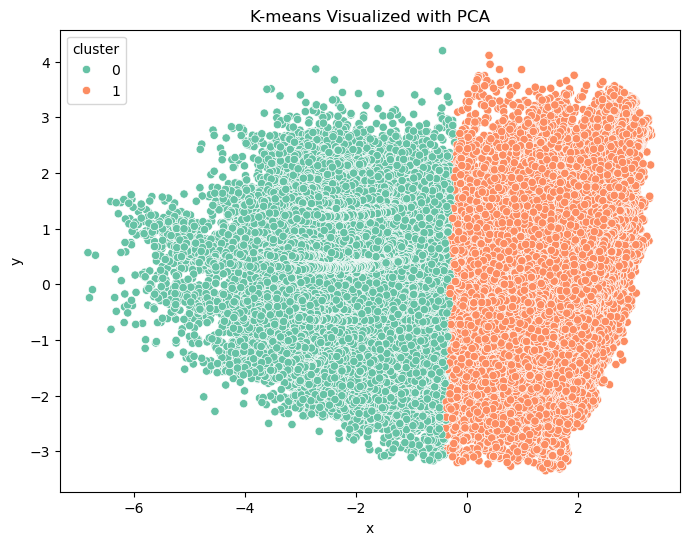

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(data=pandas_df, x="x",y="y",hue="cluster",palette="Set2")
plt.title("K-means Visualized with PCA")
plt.show()

#### **5 - Results Analysis**

##### **Supervised Learning Model**

When analyzing the results produced by our supervised learning algorithm, we can observe that they are acceptable. We managed to predict tip amounts with an average error of just a few cents, and considering the range of values in this column, this result is promising.

However, it is important to note that our GridSearch method was not very exhaustive. A broader search over values and hyperparameters could significantly improve the model. Additionally, a linear relationship between the variables was assumed, but comparing with other methods such as polynomial regression could yield better results.

Strengths:
- Solid preprocessing
- Appropriate choice of sampling metric
- Final model is not overfitted

Areas for Improvement:
- Broaden the hyperparameter search
- Scaling and transformation of the target variable
- Test and compare with different models

##### **Unsupervised Learning Model**

When analyzing the results of our model, we can conclude that they are adequate. The clusters generated are sufficiently separated to avoid negative silhouette values in the evaluation. However, the results are not optimal. This may be due to several reasons, ranging from a preprocessing approach that was not specifically tailored for clustering (it was more focused on the supervised learning model) to the possibility that our dataset simply lacks strong patterns suitable for clustering.

Our final cluster visualization shows that while the clusters are well-defined (no overlapping clusters), they do not display significant behavioral differences. The only noticeable difference is that Cluster 1 has slightly higher values on the Y-axis.

Another factor to consider is that our dimensionality reduction step may have removed some characteristic behaviors of each group, requiring a deeper analysis to draw more concrete conclusions.

Strengths:
- Functional model with acceptable results
- Final model is not overfitted
  
Areas for Improvement:
- The final cluster visualization could be improved by using PCA with three dimensions or by producing multiple plots using pairs of features.
- Preprocessing specifically tailored to clustering could be beneficial (e.g., dimensionality reduction of the problem).